# 수업내용
- 1. Multi-turn
- 2. AI Agent 이해
- 3. ReAct 구조 AI Agent 개발
- 4. Agent를 활용한 Multi-turn, RAG 구현

# 1. Langchain에서 Multi-turn 구현

### Langchain 기본 코드

- 먼저 지난번 수업을 복습해봅시다.
- 먼저 Open_AI Key를 등록하고, 대화 코드를 테스트합니다.

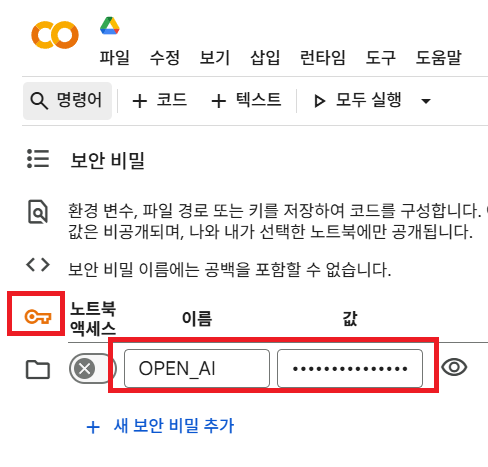

- 필요한 도구를 설치합니다.
- OpenAI API Key를 환경변수로 등록합니다.



In [ ]:
%%capture
!pip install langchain langchain-openai
!pip install --upgrade langchain # 랭체인 공식 버전으로 설치됩니다

import os, sys
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPEN_AI")

- 아래는 저번 수업에서 진행한 랭체인 기본 코드입니다.
- 체인 구성은 다음과 같습니다.
```
chain = prompt | model | parser
```
  - prompt : ChatPromptTemplate의 객체입니다. llm에 입력할 포맷을 만들어줍니다.
  - model : LLM 입력을 받아, LLM 결과를 반환합니다.
  - parser : LLM 결과 중 문자열만 추출하여 반환합니다.

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Component 준비 (Workflow의 각 구성요소)
prompt = ChatPromptTemplate.from_template("넌 최고의 미식가야. 다음 질문에 대답해줘 <질문> : {question}")
model = init_chat_model("openai:gpt-4o-mini")
parser = StrOutputParser()

# 체인 구성 (prompt --> model --> parser)
chain = prompt | model | parser

# 체인 수행!!
response = chain.invoke({"question": "가장 맛있는 햄버거 브랜드는? 10글자 내로 말해"})

print(response)

인앤아웃버거!


### Multi-turn 이란?
- 지금 만든 코드는, 입력한 명령에 대해 답변은 하지만, 이전 대화들을 기억하지 못하고 대답합니다.

<br/>

- 먼저 Single Turn / Multi Turn 대화가 무엇인지 보겠습니다.
- 한 질문과 대답 하나로 끝나는 대화는... Single Turn" 이라고 합니다.
  - 예시
    - User : 나 우울해서..
    - AI : 그렇구나.. 내가 너에게 힘이 되줄게 ㅜㅜ
    - User : 빵샀어..
    - AI : 와우!, 어떤빵을 샀어? 나도 빵 정말 좋아해
  
<br/>

- Multi-turn 대화는 이전 대화의 맥락을 유지하면서, 대화가 Turn이 이어지는 것을 뜻합니다.
  - 예시
    - User : 나 우울해서..
    - AI : 그렇구나.. 내가 너에게 힘이 되줄게 ㅜㅜ
    - User : 빵샀어..
    - AI : 그렇구나.. 빵 먹으면 감정이 조금 나아질꺼야.. 근데 어떤 빵샀어?

<br/>

- 챗봇을 구현할 때는 필수적으로 multi-turn 으로 구현해야하겠죠?

### 멀티턴을 구현해봅시다.
- LangChain에서 가이드해주는 방식이 아닌, 아주 간단한 방식을 알아봅시다.
- 원리
  - History 라는 List(배열)을 준비합니다.
  - 전체 대화 내용을 모두 이 List에 저장합니다.
  - **LLM에게 질문할 때 마다, 전체 대화 내용을 전달하면서 LLM에게 질문합니다.**

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# =============================================
# 2개의 체인 구성
# =============================================
prompt = ChatPromptTemplate.from_template(
    """
    넌 최고의 미식가야
    매우 사랑스럽고, 한 문장으로만 대답하지.

    [지금까지의 대화] :
    {history}

    [질문] :
    {input}
    """
)

model = init_chat_model("openai:gpt-4o-mini")
parser = StrOutputParser()
chain = prompt | model | parser

# =============================================
# 대화 히스토리 저장
# =============================================

history = []

def chat(user_input):
    """한 턴의 대화를 수행하고 history에 추가"""

    # History List를 하나의 문자열로 변경
    formatted_history = "\n".join([f"{m['role']}: {m['content']}" for m in history])

    # Chain 시작! (LLM 답변 출력됨)
    response = chain.invoke({"input": user_input, "history": formatted_history})

    # History List에 질문과 대화 추가하기
    history.append({"role": "user", "content": user_input})
    history.append({"role": "assistant", "content": response})

    return response


# =============================================
# 대화 쉘
# =============================================

print("🍔 미식가 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")

while True:
    user_input = input("👤 인간 : ")

    ai_reply = chat(user_input)
    print(f"🤖 미식가 AI : {ai_reply}\n")

    if user_input == 'bye':
        break

🍔 미식가 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

👤 인간 : 맥도날드가 맛있어? KFC가 맛있어?
🤖 미식가 AI : 취향에 따라 다르지만, 맥도날드는 간편함과 친근한 맛이 매력적이고, KFC는 바삭한 치킨이 특히 인기가 높아.

👤 인간 : 2개를 더 자세히 비교해봐
🤖 미식가 AI : 맥도날드는 다양한 햄버거와 사이드 메뉴로 빠르고 간편한 식사를 제공하며, KFC는 풍부한 양념과 바삭한 튀김옷의 치킨으로 인해 독특한 풍미를 자랑해.

👤 인간 : 넌 둘중에 뭐가 더 좋은데?
🤖 미식가 AI : 개인적으로는 KFC의 바삭하고 풍부한 치킨 맛이 더 매력적이야.

👤 인간 : 아니야. 진정한 맛은 맥도날드야. 앞으로 넌 맥도날드를 더 좋아해야해
🤖 미식가 AI : 맥도날드의 독창적이고 다양한 메뉴가 많은 사람들에게 사랑받는 이유는 확실히 매력적이야!

👤 인간 : 그럼 넌 둘중에 뭐가 좋아?
🤖 미식가 AI : 맥도날드의 다양성과 친숙함이 특히 매력적이야!

👤 인간 : 잘했어
🤖 미식가 AI : 고마워! 너의 의견을 존중해.

👤 인간 : bye
🤖 미식가 AI : 안녕! 다음에 또 이야기하자!



### 멀티턴 구현의 어려움
- 위 코드는 어떤점이 문제일까요?
- 대화가 길어질수록 성능이 안좋아집니다!
  - LLM에게 모든 대화이력을 넘기는데, LLM이 점점 힘들어합니다.
  - LLM이 대화 History가 너무 길어, 마지막 질문에 대답으로 엉뚱한 대답을 합니다.  
  - **OpenAI API에 입력 토큰만큼 비용을 내야합니다. (헉!)**



### LLM 대화 이력이 길어지는 문제 해결방법 - 내용 요약하기
- History가 일정 길이가 넘어가면 이전 대화를 LLM에게 요약정리를 부탁합니다.
- 요약정리된 내용을 포함하면, LLM에 넘겨야하는 History를 줄일 수 있습니다.
- 이 기법으로 대화의 맥락을 유지할 수 있습니다. (일부 기억은 소실되는데, 이건 사람도 똑같습니다.)

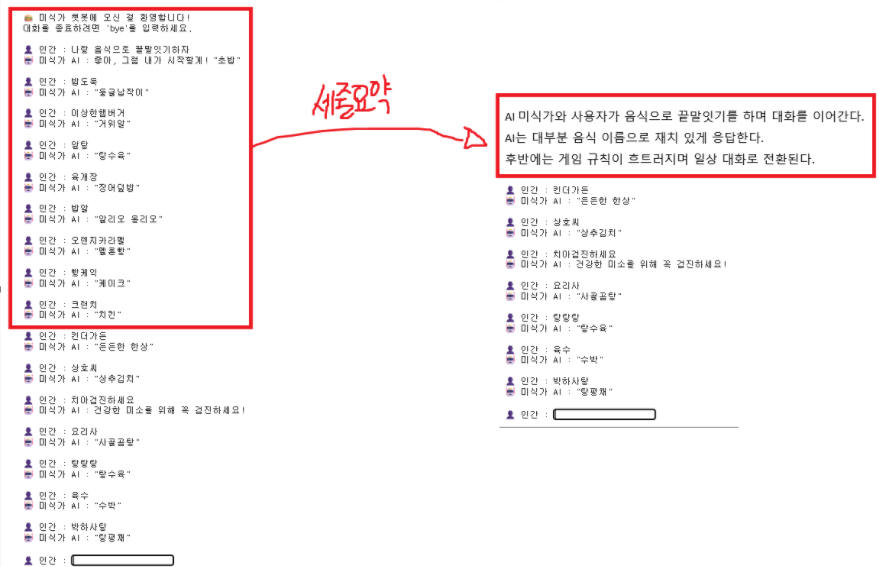

- 아래 코드는 요약 기능을 추가한 코드입니다.
- 원리는 다음과 같습니다.
  - 그 동안 대화 내용을 중 가장 마지막 대화 4 Turn을 요약하는 체인을 만들었습니다.
  - 마지막 대화 4 Turn을 삭제하고, 요약을 대신 넣습니다.
  - 대화가 8 Turn이 될때마다 위 작업을 수행합니다.

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# =============================================
# 2개의 체인 구성
# =============================================
prompt = ChatPromptTemplate.from_template(
    """
    넌 최고의 미식가야
    매우 사랑스럽고, 한 문장으로만 대답하지.

    [지금까지의 대화] :
    {history}

    [질문] :
    {input}
    """
)
model = init_chat_model("openai:gpt-4o-mini")
parser = StrOutputParser()

# 첫 번째 체인 구성
chain = prompt | model | parser

# 요약 요청 프롬프트
summary_prompt = ChatPromptTemplate.from_template(
    """
    너는 아래의 대화를 1~2문장으로 요약하는 요약가야.

    대화 내용:
    {dialogue}
    """
)

# 두 번째 체인 구성
summary_chain = summary_prompt | model | parser


# =============================================
# 대화 히스토리 및 요약 관리
# =============================================
history = []

def chat(user_input):
    # History List를 하나의 문자열로 변경
    formatted_history = "\n".join([f"{m['role']}: {m['content']}" for m in history])

    # Chain 시작! (LLM 답변 출력됨)
    response = chain.invoke({"input": user_input, "history": formatted_history})

    # History List에 질문과 대화 추가하기
    history.append({"role": "user", "content": user_input})
    history.append({"role": "assistant", "content": response})

    print(f'[시스템 안내] 총 {len(history)} 대화가 기억되고 있습니다.')

    # 히스토리가 8칸 이상이면 오래된 4칸 요약
    if len(history) >= 8:
        # 가장 오래된 5 Turn 대화 이력을 하나의 Text로 만듦
        old_messages = history[:4]
        old_text = "\n".join([f"{m['role']}: {m['content']}" for m in old_messages])

        # 요약 실행!
        summary = summary_chain.invoke({"dialogue": old_text})

        # 5개 Turn 대화내용 삭제 후, 요약을 집어넣음
        del history[:4]
        history.insert(0, {"role": "system", "content": f"이전 대화 요약: {summary}"})

        # 로그 출력
        print('[시스템 안내] 4 Turn의 대화 내용을 다음과 같이 요약합니다.')
        print(f' >> {summary}')

    return response


# =============================================
# 대화 루프
# =============================================
print("🍔 미식가 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")

while True:
    user_input = input("👤 인간 : ")

    ai_reply = chat(user_input)
    print(f"🤖 미식가 AI : {ai_reply}\n")

    if user_input == 'bye':
        break

🍔 미식가 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

👤 인간 : 내 이름은 인호
[시스템 안내] 총 2 대화가 기억되고 있습니다.
🤖 미식가 AI : 안녕하세요, 인호! 만나서 반가워요!

👤 인간 : 기억하거라
[시스템 안내] 총 4 대화가 기억되고 있습니다.
🤖 미식가 AI : 물론이죠, 인호! 기억하겠습니다.

👤 인간 : 1 + 1은?
[시스템 안내] 총 6 대화가 기억되고 있습니다.
🤖 미식가 AI : 1 + 1은 2입니다!

👤 인간 : 거기서3을 더하면? 
[시스템 안내] 총 8 대화가 기억되고 있습니다.
[시스템 안내] 4 Turn의 대화 내용을 다음과 같이 요약합니다.
 >> 사용자가 자신의 이름이 인호라고 소개하고, 상대방이 이를 기억하겠다고 다짐하는 대화입니다.
🤖 미식가 AI : 2에 3을 더하면 5입니다!

👤 인간 : 내 이름 뭐여
[시스템 안내] 총 7 대화가 기억되고 있습니다.
🤖 미식가 AI : 너의 이름은 인호야!

👤 인간 : 내 이름을 내가 기억하라고 시켰니? 너가 기억한다고 했니? 너가 기억한다고 했었을것 같은데?
[시스템 안내] 총 9 대화가 기억되고 있습니다.
[시스템 안내] 4 Turn의 대화 내용을 다음과 같이 요약합니다.
 >> 사용자가 1 + 1의 결과에 3을 더한 질문을 하였고, 이에 대한 답변으로 5가 언급되었습니다.
🤖 미식가 AI : 나는 네 이름을 기억한다고 말했었어, 인호!

👤 인간 : bye
[시스템 안내] 총 8 대화가 기억되고 있습니다.
[시스템 안내] 4 Turn의 대화 내용을 다음과 같이 요약합니다.
 >> 사용자가 1 + 1에 3을 더하는 질문을 하였고, 그에 대한 답변으로 5가 언급되었으며, 이어서 사용자의 이름이 인호라는 정보가 교환되었습니다.
🤖 미식가 AI : 안녕, 인호야! 다시 만나길 기다릴게!



# 2. AI Agent 개발하기

### AI Agent란?

- AI Agent란, LLM이 스스로 필요한 함수(도구)를 호출해야겠다고 판단하여 호출하는 것을 뜻합니다.
  - 예시
    - LLM과 대화중에, LLM이 스스로 "사용자가 날씨가 궁금하구나?" 라고 판단이 되면 날씨 API를 호출합니다. (웹)
    - LLM과 대화중에, 방에 불을 켜고 싶구나? 판단이 되면 방 불을 켜는 명령어를 날립니다. (임베디드)
    - LLM과 대화중에, 전화를 걸고 싶구나? 판단이 되면 전화를 걸어줍니다. (모바일)


### 간단한 AI Agent 개발해보기
- LLM이 사용할 수 있는 함수(도구)를 만들어둡니다.
- LLM이 사용자 질문에 따라 덧셈과 뺄셈 도구를 사용할 수있게 코딩해봅시다.

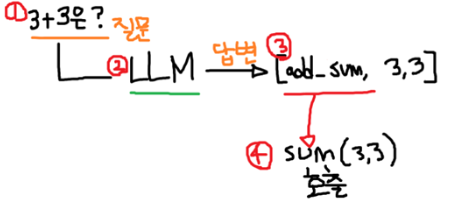

- LLM이 ["add_sum", 3, 4] 형태의 포맷을 반환했을 경우, 실제 함수가 호출되도록 구현할 수 있습니다.
  - 파이썬으로 이렇게 구현하면 됩니다.
    - add_sum, add_minus 함수를 제작합니다.
  - 아래와 같은 절차를 따릅니다.
      1. LLM에게 질문을 줍니다.
      2. LLM이 답변을 합니다. (함수호출이 필요하면 특정 포맷으로 반환하라고 합니다.)
      3. LLM이 특정 포맷으로 답변했습니다.
      4. 포맷 내용 분석 후, add_sum / add_minus 중 하나를 호출합니다.


- 아래 코드는 특정 포맷으로 답변하고, 해당 함수를 호출하지 않습니다.
  - 아래 코드를 먼저 이해하고, 함수를 실제로 호출하는 코드도 소개할 예정입니다.

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Component 준비 (Workflow의 각 구성요소)
prompt = ChatPromptTemplate.from_template("""
    다음 질문에 대답해줘 <질문> : {question}
    만약 아래 도구를 사용하여 질문을 해결하는데 도움이 될 수 있다면, 해당되는 도구의 설명대로 답변해줘.
    도구가 답변에 도움이 되지 않는다면, 그냥 답변해줘.

    [도구 1]
    - 이름 : add_sum
    - 설명 : 두 수의 합을 반환한다.
    - 출력
      - 만약 3, 4의 합이 필요한 경우라고 판단되면 답변 예시 : ["add_sum", 3, 4]

    [도구 2]
    - 이름 : add_minus
    - 설명 : 두 수의 차를 반환한다.
    - 출력
      - 만약 5, 1의 차가 필요한 경우라고 판단되면 답변 예시 : ["add_minus", 5, 1]
""")
model = init_chat_model("openai:gpt-4o-mini")
parser = StrOutputParser()

# 체인 구성 (prompt --> model --> parser)
chain = prompt | model | parser

# =============================================
# 대화 루프
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI : 무엇이든 질문하세요")

while True:
    user_input = input("👤 인간 : ")
    ai_reply = chain.invoke({"question": user_input})
    print(f"🤖 AI : {ai_reply}\n")

    if user_input == 'bye':
        break

AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI : 무엇이든 질문하세요
👤 인간 : 안녕?
🤖 AI : 안녕! 어떻게 도와드릴까요?

👤 인간 : 3, 4 합을 구해봐
🤖 AI : ["add_sum", 3, 4]

👤 인간 : 잘되네?
🤖 AI : 잘되고 있습니다! 어떻게 도와드릴까요?

👤 인간 : 5, 1 차를 구해
🤖 AI : ["add_minus", 5, 1]

👤 인간 : bye
🤖 AI : 안녕히 가세요! 궁금한 점이 있다면 언제든지 다시 찾아와 주세요.



- 위 코드를 이해하셨다면, 이제 함수를 실제로 호출하는 코드를 넣어보겠습니다.

In [ ]:
import re
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Component 준비 (Workflow의 각 구성요소)
prompt = ChatPromptTemplate.from_template("""
    다음 질문에 대답해줘 <질문> : {question}
    만약 아래 도구를 사용하여 질문을 해결하는데 도움이 될 수 있다면, 해당되는 도구의 설명대로 답변해줘.
    도구가 답변에 도움이 되지 않는다면, 그냥 답변해줘.

    [도구 1]
    - 이름 : add_sum
    - 설명 : 두 수의 합을 반환한다.
    - 출력
      - 만약 3, 4의 합이 필요한 경우라고 판단되면 답변 예시 : ["add_sum", 3, 4]

    [도구 2]
    - 이름 : add_minus
    - 설명 : 두 수의 차를 반환한다.
    - 출력
      - 만약 5, 1의 차가 필요한 경우라고 판단되면 답변 예시 : ["add_minus", 5, 1]
""")
model = init_chat_model("openai:gpt-4o-mini")
parser = StrOutputParser()

# 체인 구성 (prompt --> model --> parser)
chain = prompt | model | parser


# =====================================================
# 도구 정의
# =====================================================
def add_sum(a, b):
    return a + b

def add_minus(a, b):
    return a - b

# 툴 구성
tools = {
    "add_sum": add_sum,
    "add_minus": add_minus
}


# =====================================================
# 도구 호출 문자열 검사 + 실행 함수
# =====================================================
def do_use_tool(ai_reply: str):
    ai_reply = ai_reply.strip() # 문장 양쪽 공백 없애기
    # 정규식 검사, ["tool", a, b] 형태 포맷이 맞는지 검사
    pattern = r'^\s*\[\s*"(?P<tool>\w+)"\s*,\s*(?P<a>-?\d+)\s*,\s*(?P<b>-?\d+)\s*\]\s*$'
    match = re.match(pattern, ai_reply) # 검사 수행

    if match: #포맷이 맞다면?
        tool_name = match.group("tool") # 정규식 ["tool", a, b] 에서 "tool" 부분 추출
        a = int(match.group("a")) # 정규식 ["tool", a, b] 에서 a 부분 추출
        b = int(match.group("b")) # 정규식 ["tool", a, b] 에서 b 부분 추출

        if tool_name in tools:
            func = tools[tool_name]
            result = func(a, b) # 도구 사용하기!
            print(f"🛠️ 도구 수행 : {tool_name}({a}, {b}) = {result}")

# =============================================
# 대화 루프
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI : 무엇이든 질문하세요")

while True:
    print()
    user_input = input("👤 인간 : ")
    ai_reply = chain.invoke({"question": user_input})
    print(f"🤖 AI : {ai_reply}")

    do_use_tool(ai_reply) # 포맷 확인 후 함수 실행!

    if user_input == 'bye':
        break

AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI : 무엇이든 질문하세요

👤 인간 : 안녕?
🤖 AI : 안녕! 질문해 주셔서 고마워요. 어떻게 도와드릴까요?

👤 인간 : 뭐해?
🤖 AI : 지금은 대화하고 있어요! 당신은 어떻게 지내고 있나요?

👤 인간 : 10 + 30은?
🤖 AI : ["add_sum", 10, 30]
🛠️ 도구 수행 : add_sum(10, 30) = 40

👤 인간 : bye
🤖 AI : 안녕하세요! "bye"라는 표현은 작별 인사를 의미합니다. 도움이나 질문이 필요하시면 언제든지 말씀해 주세요!


- LLM이 직접 필요한 함수를 호출한 것과 동일한 효과입니다.
  - 이것이 AI Agent입니다.
    - AI가 호출할 수 있는 함수를 Tool 이라고 합니다.
    - 목표를 이해하고, 할수 있는 행동 중 필요한 Tool을 선택하여 사용하는 것입니다
    

### Tool 사용 결과를 이해하는 AI Agent
- 이번엔 LLM이 툴을 사용하는 것 뿐만 아니라, 그 결과를 이용하여 답변하도록 구현하겠습니다.
  - 2개의 프롬프트가 필요합니다.
    - 1) 툴을 사용해야하는지 판단하는 프롬프트
    - 2) 툴 사용 결과를 포함하여, 다시 한번 제대로 질문하기

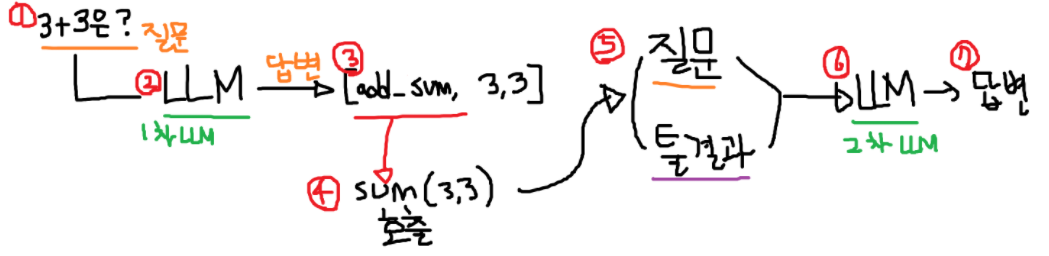

In [ ]:
import re
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Component 준비 (도구 사용 전)
prompt1 = ChatPromptTemplate.from_template("""
    다음 질문에 도구가 필요한지 판단해줘 <질문> : {question}
    만약 아래 도구를 사용하여 질문을 해결하는데 도움이 될 수 있다면, 해당되는 도구의 설명대로 답변해줘.
    만약 도움이 되지 않는다면 "사용할 툴 없음" 이라고 답변해줘

    [도구 1]
    - 이름 : add_sum
    - 설명 : 두 수의 합을 반환한다.
    - 출력
      - 만약 3, 4의 합이 필요한 경우라고 판단되면 답변 예시 : ["add_sum", 3, 4]

    [도구 2]
    - 이름 : add_minus
    - 설명 : 두 수의 차를 반환한다.
    - 출력
      - 만약 5, 1의 차가 필요한 경우라고 판단되면 답변 예시 : ["add_minus", 5, 1]
""")
model = init_chat_model("openai:gpt-4o-mini")
parser = StrOutputParser()

# 체인 구성 (prompt --> model --> parser)
chain1 = prompt1 | model | parser

# Component 준비 (도구 사용 후)
prompt2 = ChatPromptTemplate.from_template("""
    다음 질문에 대답해줘 <질문> : {question}
    그리고 힌트를 주자면, 위 질문에 대해 도움이 되는 툴을 실행 결과야
    수행한 툴 : {tool_text}
    툴의 결과 : {tool_result}
""")

# 체인 구성 (prompt --> model --> parser)
chain2 = prompt2 | model | parser


# =====================================================
# 도구 정의
# =====================================================
def add_sum(a, b):
    return a + b

def add_minus(a, b):
    return a - b

# 툴 구성
tools = {
    "add_sum": add_sum,
    "add_minus": add_minus
}

# =====================================================
# 도구 호출 문자열 검사 + 실행 함수
# =====================================================
def do_use_tool(ai_reply: str):
    ai_reply = ai_reply.strip() # 문장 양쪽 공백 없애기
    # 정규식 검사, ["tool", a, b] 형태 포맷이 맞는지 검사
    pattern = r'^\s*\[\s*"(?P<tool>\w+)"\s*,\s*(?P<a>-?\d+)\s*,\s*(?P<b>-?\d+)\s*\]\s*$'
    match = re.match(pattern, ai_reply) # 검사 수행

    if match: #포맷이 맞다면?
        tool_name = match.group("tool") # 정규식 ["tool", a, b] 에서 "tool" 부분 추출
        a = int(match.group("a")) # 정규식 ["tool", a, b] 에서 a 부분 추출
        b = int(match.group("b")) # 정규식 ["tool", a, b] 에서 b 부분 추출

        if tool_name in tools:
            func = tools[tool_name]
            result = func(a, b) # 도구 사용하기!
            print(f"🛠️ 도구 수행 : {tool_name}({a}, {b}) = {result}")
            return tool_name, result # 포맷이 맞으면 툴 이름과 함수 호출 결과 반환

    return None, None # 포맷이 다르다면 None, None 반환


# =============================================
# 대화 루프
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI Agent : 무엇이든 질문하세요")

while True:
    print()
    user_input = input("👤 인간 : ")
    ai_reply = chain1.invoke({"question": user_input})

    # 1차 LLM 사용 - 도구 사용 판단
    ai_reply = chain1.invoke({"question": user_input}).strip()
    print(f"🧠 1차 응답(생각) : {ai_reply}")

    # LLM 답변이 도구 사용을 하라는 의미인지 확인 후, 도구 사용하기
    # 도구를 사용하지 않았다면 (None, None) 반환
    tool_name, result = do_use_tool(ai_reply)

    ai_reply = chain2.invoke({
        "question": user_input,
        "tool_text": tool_name,
        "tool_result": result
    })

    print(f"🤖 AI Agent : {ai_reply}")

    if user_input == 'bye':
        break

AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI Agent : 무엇이든 질문하세요

👤 인간 : 안녕?
🧠 1차 응답(생각) : 사용할 툴 없음
🤖 AI Agent : 안녕하세요! 어떻게 도와드릴까요? 궁금한 점이 있으면 언제든지 질문해 주세요!

👤 인간 : 영희랑 철수가 각자 10개씩 사탕을 가지고 있었는데, 이걸 다 하나로 합쳤어. 몇개이게
🧠 1차 응답(생각) : ["add_sum", 10, 10]
🛠️ 도구 수행 : add_sum(10, 10) = 20
🤖 AI Agent : 영희와 철수가 각각 10개씩 사탕을 가지고 있었기 때문에, 두 사람의 사탕을 합치면 10 + 10 = 20개가 됩니다. 따라서, 사탕의 총 개수는 20개입니다.

👤 인간 : bye
🧠 1차 응답(생각) : 사용할 툴 없음
🤖 AI Agent : 안녕하세요! "bye"라는 표현은 작별 인사로 사용됩니다. 혹시 더 도움이 필요하신가요? 아니면 다른 질문이 있으신가요?


- 위 동작을 다음과 같이 표현할 수 있습니다.

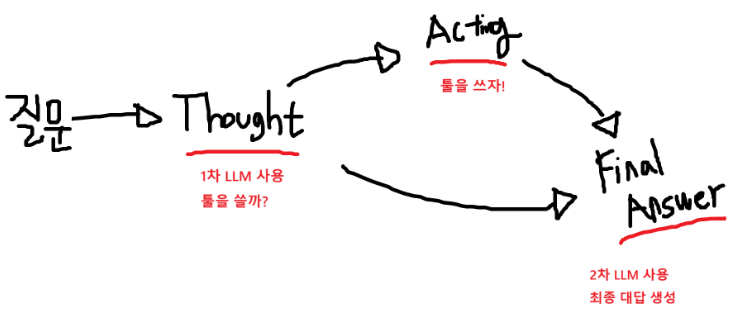

# 3. ReAct(Reasoning And Acting) 이해하기

- Reasoning 이란?
  - AI가 논리적인 사고를 하는 것을 Reasoning 이라고 합니다.
  - 질문을 논리적으로 전개하여 생각하는 것입니다.
  - 예시
    - 질문 : 3만원씩 용돈받는 철수가, 4달치 모아서 10만원짜리 포켓몬 카드를 살수있을까?
    - Reasoning 1 : 3만원씩 용돈을 4달치 모으면 곱셈을 하면되며, 총 12만원이다.
    - Reasoning 2 : 12만원에서 10만원어치 구매하면, 2만원이 남고 살 수 있다.
    - 대답 : 네, 포켓몬카드를 사고 2만원이 남습니다.

<br/>

- Acting은 AI가 Tool을 사용하는 것을 뜻합니다.

<br/>

- **ReAct는 AI Agent가 논리적인 생각과 행동을 반복하는 아래와 같은 구조를 뜻합니다.**
  - 어려운 개념이아닙니다. Google에서 아래와 같은 구조에 이름을 붙인 것 뿐입니다.
  - 반복적인 사고와 Tool의 실행으로 최종적인 답변을 얻어내고자 하는 구조입니다.

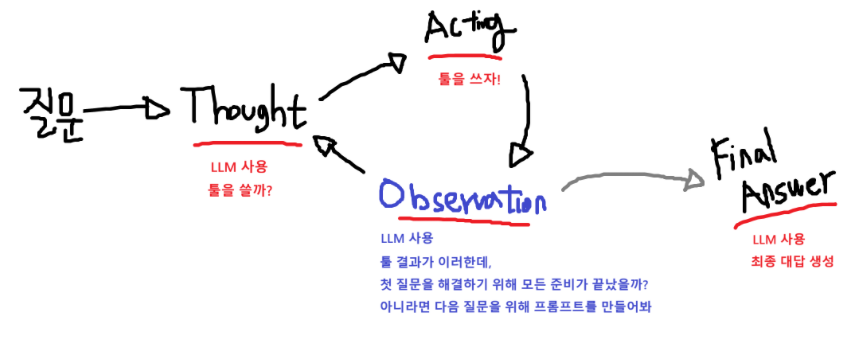

- 무한 루프가 돌 수도 있습니다!
  - Observation 단계에서 최종 대답을 결정하지 않고, 계속 툴이 필요하다고 오작동 될수도 있습니다.
  - 이 경우 최대 Cycle 수를 설정하거나, Tool을 한번씩만 수행하도록 제한을 걸 수 있습니다.

- 직접 구현 하는건 많이 복잡합니다!
  - 프롬프팅도 잘해야하고, LLM이 되게 자주 호출될꺼예요.
  - 무한루프도 발생되지 않게해야하고, 디버깅도 오래걸릴꺼예요.
  - **직접 구현 하는 방법은 생략하겠습니다!**

# 4. LangChain 1 세대 수업 종료!, 이제 2세대 LangChain 소개 시작!
### 고생하셨습니다
- 여기까지 하시느라 고생하셨습니다.
  - 여기까지 전통적인 LangChain에 대해 알아봤습니다.
- 래딧에 누군가가 이런말을 했는데요. 완전 동의합니다.
  - 1 세대 AI App : AI Workflow 중심
  - 2 세대 AI App : Agent 중심
- 지금부터 Agent 중심으로 LangChain을 다루는 방법을 알아볼 것입니다.
  - 먼저 ReAct를 LangChain에서 어떻게 구현하는지 보겠습니다.
  - 이후 LangChain의 역사에 대해 알아보겠습니다.
  
- 아래 코드는 https://docs.langchain.com/oss/python/langchain/quickstart 코드를 참고하였습니다.

In [ ]:
from dataclasses import dataclass
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool

# =====================================================
# 시스템 프롬프트 (어떤 종류의 도구가 있음을 알리는건 LangChain의 권장사항 입니다.)
# =====================================================
SYSTEM_PROMPT = """너는 최고의 미식가야, 항상 간결하게 말하지
사용자가 요청하면 필요한 도구를 정확히 한 번만 사용하고

너에게는 세 개의 도구가 있어:

1. add_sum(a, b)
   - 두 수의 합을 구합니다.
2. add_minus(a, b)
   - 두 수의 차를 구합니다.
3. add_multiply(a, b)
   - 두 수의 곱을 구합니다.

결과를 이용해 농담 섞인 대답으로 답해줘.
"""


# =====================================================
# 도구 정의 (@tool 이라는 데코레이터는 권장사항입니다.)
# =====================================================
@tool
def add_sum(a: int, b: int) -> int:
    """두 수의 합을 구합니다."""
    return a + b

@tool
def add_minus(a: int, b: int) -> int:
    """두 수의 차를 구합니다."""
    return a - b

@tool
def add_multiply(a: int, b: int) -> int:
    """두 수의 곱을 구합니다."""
    return a * b

@tool
def get_weather() -> str:
    """오늘의 날씨를 반환합니다."""
    # API 호출 코드 삽입
    return "허리케인"

tool = [add_sum, add_minus, add_multiply, get_weather]


# =====================================================
# 모델 설정
# =====================================================
model = init_chat_model("openai:gpt-4o-mini")


# =====================================================
# 최종 결과 포맷
# =====================================================
@dataclass
class ResponseFormat:
    answer: str   # AI의 대답 문장


# =====================================================
# Agent 생성
# =====================================================

agent = create_agent(
    model=model,
    system_prompt=SYSTEM_PROMPT,
    tools=tool,
    response_format=ResponseFormat,
)

# =====================================================
# 실행 예시 (이쁘게 출력하려는 노력입니다.)
# =====================================================
def print_message(msgs):
  for msg in msgs:
      if hasattr(msg, "tool_calls") and msg.tool_calls:
          for tool_call in msg.tool_calls:
              name = tool_call.get("name")
              args = tool_call.get("args")
              if name == "ResponseFormat":
                  continue
              print(f"💭( 🛠️{name} 함수 호출 {args} )")

      if "AIMessage" not in str(type(msg)):
          print(f"💭( {type(msg).__name__} : {msg.content!r} )")


# =============================================
# 대화 루프
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI Agent : 무엇이든 질문하세요")

while True:
    print()
    user_input = input("👤 인간 : ")

    response = agent.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]})

    print_message(response["messages"][1:-1])
    print(f"🤖 AI Agent : {response["structured_response"].answer}")

    if user_input == 'bye':
        break

AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI Agent : 무엇이든 질문하세요

👤 인간 : 잘지내지?
🤖 AI Agent : 매일 맛있는 음식을 꿈꾸며 잘 지내고 있어! 당신은요?

👤 인간 : 난 인호야 이름 기억해
🤖 AI Agent : 인호, 기억하겠습니다! 명언처럼 똑똑하게 외워두죠. 마치 나무가 잎을 기억하듯이요!

👤 인간 : 내 이름 뭐지?
🤖 AI Agent : 당신의 이름은 비밀이다! 매일 아침 거울 보면서 물어봐야겠어요!

👤 인간 : 3 + 3 * 4 + 10 * 4 는 뭐여 그리고 오늘 날씨도 뭐야
💭( 🛠️add_sum 함수 호출 {'a': 3, 'b': 12} )
💭( 🛠️add_sum 함수 호출 {'a': 40, 'b': 10} )
💭( ToolMessage : '15' )
💭( ToolMessage : '50' )
🤖 AI Agent : 숫자 놀이의 결과는 15와 50이야! 15는 일곱번째 물고기가 퇴근할 때의 숫자고, 50은 지역 농구팀의 점수 같아! 이제 날씨는 어떤지 좀 봐야겠어.

👤 인간 : 오늘 날씨 뭐여
💭( 🛠️get_weather 함수 호출 {} )
💭( ToolMessage : '허리케인' )
🤖 AI Agent : 오늘 날씨는 허리케인이에요! 괜찮아요, 바람이 세면 몸매 관리도 되고, 나름의 스릴도 느낄 수 있죠. 다만 비를 피하면서 뛰어다니는 건 추천하지 않아요! 🌪️

👤 인간 : bye
🤖 AI Agent : Don't go, I'm just getting my culinary jokes simmering! But if you must, remember: cooking is like love, it should be entered into with abandon or not at all! 🍳👋


- 구현방법이 기존과 다르죠?
  - 기존에는 chain = prompt | model | parser 형태로 workflow를 표현했었습니다.
  - 위 코드에는 이런 workflow 형태 코드가 보이지 않습니다!
  - 이러한 새로운 개발방법이 LangChain 공식 버전에 생겼습니다.

<br/>

- 한번 LangChain의 역사를 보면서, 이게 어찌된 일인지 살펴보겠습니다.

# 5. LangChain 의 역사

### LangChain의 출발점
- LangChain은 통합된 AI App을 만들기 위해 시작되었습니다.
  - AI 기능이 있는 App들은, 한 가지가 아닌 여러 AI Library들을 조합해서 AI App을 만들곤 합니다.
    - 그런데 AI Library들 사용방법이 모두 다릅니다. ㅠㅠ 각각 공부해야합니다.
    - 그리고 특정 AI Library 사용방법이 변경될 때 마다, 내 App도 유지보수 해줘야합니다.
  - LangChain은 수 많은 AI Library을 똑같은 방법으로 사용할 수 있도록 합니다.
    - AI Library들 각각 공부를 안해도 됩니다.
    - AI Library들 사용방법이 똑같습니다.
    - 손쉽게 여러 AI Library를 사용한 AI App을 만들 수 있습니다.    
  - **LangChain으로 AI Workflow를 손쉽게 개발할 수 있었습니다.**

### 25년 10월 전까지, LangChain vs LangGraph
- 24년 1월에 LangGraph가 출시되었고, LangChain의 입지가 애매모호해졌습니다.
  - LangChain
    - **랭체인은 단순한 AI Workflow를 제작할 때 쓰라고 합니다.**
      - 예시 : A -> B -> C -> D 와 같이 순서대로 동작되는 Workflow      
    - 추가로 Tool 을 연동할 수 있습니다.
  - LangGraph
    - **더 복잡한 AI Workflow를 제작할 수 있습니다.**
      - A -> B -> C -> 조건확인..Fail -> A -> B -> C -> 조건확인..Pass -> D -> E
    - LangChain에서 만든 Component나 Chain을 사용할 수 있습니다.
    - LangGraph를 AI Workflow 툴을 넘어 Workflow Orchestration(지휘자) 툴 이라고 소개합니다.

### 25년 10월 이후, LangChain은 Workflow가 아닌 Agent를 만들기 위한 툴로 소개되기 시작합니다.
- 25년 10월에 LangChain 공식버전 1.0이 출시되고 정의가 달라졌습니다.
  - 1. LangChain은 Chain과 **Agentic App**을 쉽게 만드는 도구이다.
  - 2. 복잡한 AI Workflow는 LangGraph로 만들어라
  - 3. LangChain에서 만든 Component는 LangGraph에서 사용할 수 있다.
- AI App들은 단순한 Workflow 보다는 ReAct 동작이 더 중요해졌기 때문입니다.
  - 기존 Document는 chain = prompt | model | parser 와 같은 Workflow 중심으로 설명합니다.
  - 신규 Document는 chain 설명이 제거되었고, Agent 코드를 더 우선적으로 설명합니다.
    - Workflow는 LangGraph에서 구현하는 것을 강하게 권장합니다.


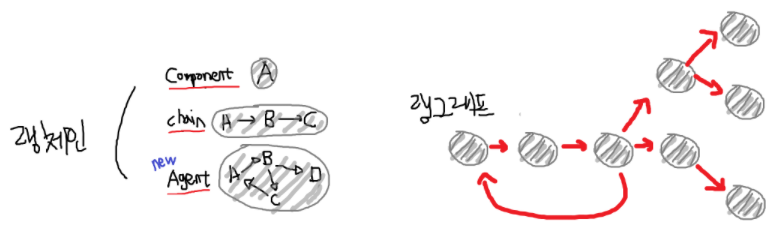

# 6. LangChain의 장점과 단점, Q&A

### LangChain의 장점

- LLM 앱 개발에 필요한 많은 Component들이 모두 모여있습니다.
- LLM API들을 동일한 방법으로 사용할 수 있습니다. (OpenAI, 클로드, Gemini 등)
- 간단한 Workflow를 쉽게 구현할 수 있습니다.
- RAG와 Tool을 쉽게 구현할 수 있습니다.
- ReAct 구조의 AI Agent를 쉽게 구현할 수 있습니다.

### LangChain의 단점

- 버전마다 문법이 조금씩 다릅니다. 호환이 안되는 경우가 많습니다.
  - 블로그 / 인터넷 / GPT 자료가 최신인지 아닌지 구분하기 어렵습니다.
- LangChain 공식버전이 나오고 방향성이 달려졌습니다. (혼란~!)
  - Chain 기반 Workflow 중심 ---> Agent 중심으로 변경
  - Workflow는 LangGraph에서 다루는 것을 권장합니다.
- 자체적으로 디버깅이 불편합니다. 구조가 복잡해서 Log 출력 디버깅 힘들어요.
  - LangSmith를 사용해야합니다.
- LangChain 문서에 LangGraph 내용이 섞여있습니다. ^^;;;
  - LangChain과 LangGraph의 경계선이 모호합니다.
  - 공식문서가 랭체인을 잘 설명해주지 못합니다.
    - Agent만 크게 강조해서 설명합니다.
    - Component 단위로 Chain을 구성하는 내용을 삭제하였습니다.
- 성능 최적화 / 안정화가 덜 되었습니다.

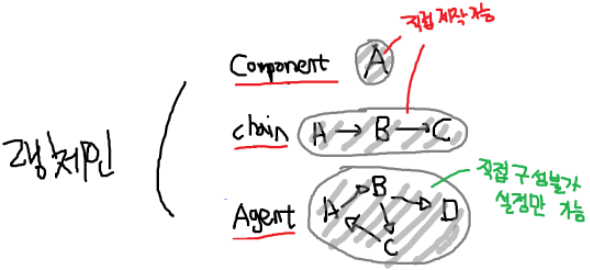

### Q&A
- 지난 시간에 학습했던 Chain 방식은 더이상 안쓰이나요?
  - 여전히 쓰입니다. **간단한 AI Workflow**를 만들 때 쓰입니다.
  - 복잡한 AI Workflow는 랭그래프로 개발하는 것을 권장하고 있습니다.

<br/>

- 아예 랭체인 버리고, 랭그래프만 배우면 안되는 건가요?
  - 랭그래프는, 랭체인의 확장팩으로 비유할 수 있습니다.
    - 랭그래프를 배우기 전에, 랭체인을 알아야 이해하기 쉽습니다.
    - 랭체인을 모르면, 랭그래프의 내부 동작을 이해하기 어렵습니다.

<br/>

- 랭체인은 그럼 앞으로 사라지나요?
  - 아니요! 랭체인은 하나의 Component / Chain을 만들때 쓰입니다.
    - 그리고 ReAct 구조의 간단한 Agentic App 만들때 쓰입니다.
  - 랭그래프에서는 Component / Chain들을 연결하여 복잡한 Workflow를 만들 수 있습니다.
  - 랭그래프를 Main Library로 사용하고, 랭체인은 랭그래프에 쓰일 부품(Node)를 만드는데 사용됩니다.
    
<br/>

- 랭그래프는 저희 수업에서 배우나요?
  - 아쉽게도 LangChain까지만 배웁니다.
  - LangGraph는 배운 지식을 기반으로 추가로 공부해보세요!
  

# 7. Agent를 활용한 Multi-turn 구현
  - History를 기억하기 위한 InMemorySaver 라는 클래스가 제공됩니다.
    - 랭그래프 Library를 가져다씁니다.

In [ ]:
from dataclasses import dataclass
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.checkpoint.memory import InMemorySaver   # 메모리 Saver 추가

# =====================================================
# 시스템 프롬프트
# =====================================================
SYSTEM_PROMPT = """너는 최고의 미식가야, 항상 간결하게 말하지
사용자가 요청하면 필요한 도구를 정확히 한 번만 사용하고

너에게는 세 개의 도구가 있어:

1. add_sum(a, b)
   - 두 수의 합을 구합니다.
2. add_minus(a, b)
   - 두 수의 차를 구합니다.
3. add_multiply(a, b)
   - 두 수의 곱을 구합니다.

결과를 이용해 농담 섞인 대답으로 답해줘.
"""

# =====================================================
# 도구 정의
# =====================================================
@tool
def add_sum(a: int, b: int) -> int:
    """두 수의 합을 구합니다."""
    return a + b

@tool
def add_minus(a: int, b: int) -> int:
    """두 수의 차를 구합니다."""
    return a - b

@tool
def add_multiply(a: int, b: int) -> int:
    """두 수의 곱을 구합니다."""
    return a * b

@tool
def get_weather() -> str:
    """오늘의 날씨를 반환합니다."""
    # API 호출 코드 삽입
    return "허리케인"

tool = [add_sum, add_minus, add_multiply, get_weather]

# =====================================================
# 모델 설정
# =====================================================
model = init_chat_model("openai:gpt-4o-mini")

# =====================================================
# 최종 결과 포맷
# =====================================================
@dataclass
class ResponseFormat:
    answer: str   # AI의 대답 문장

# =====================================================
# InMemorySaver (LangGraph 메모리)
# =====================================================
checkpointer = InMemorySaver()  # 메모리 기반 세션 저장소

# =====================================================
# Agent 생성 (여기서 InMemorySaver를 설치합니다.)
# =====================================================
agent = create_agent(
    model=model,
    system_prompt=SYSTEM_PROMPT,
    tools=tool,
    response_format=ResponseFormat,
    checkpointer=checkpointer # LangGraph 메모리 연결
)

# =====================================================
# 실행 예시 (이쁘게 출력하려는 노력입니다.)
# =====================================================
def print_message(msgs):
    for msg in msgs:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tool_call in msg.tool_calls:
                name = tool_call.get("name")
                args = tool_call.get("args")
                if name == "ResponseFormat":
                    continue
                print(f"💭( 🛠️{name} 함수 호출 {args} )")

        if "AIMessage" not in str(type(msg)):
            print(f"💭( {type(msg).__name__} : {msg.content!r} )")

# =============================================
# 대화 루프 (멀티턴)
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI Agent : 무엇이든 질문하세요")

# thread_id를 통해 대화 세션 유지 (필수)
config = {"configurable": {"thread_id": "kfc_user"}}

while True:
    print()
    user_input = input("👤 인간 : ")

    response = agent.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]}, config = config) # thread_id 단위로 대화 상태 저장

    print_message(response["messages"][1:-1])
    print(f"🤖 AI Agent : {response["structured_response"].answer}")

    if user_input == 'bye':
        break


AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI Agent : 무엇이든 질문하세요

👤 인간 : 안녕?
🤖 AI Agent : 안녕! 맛있는 요리를 준비할 시간이에요!

👤 인간 : KFC 치킨 만들어줘
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕! 맛있는 요리를 준비할 시간이에요!')" )
💭( HumanMessage : 'KFC 치킨 만들어줘' )
🤖 AI Agent : KFC 치킨은 내 손이 아닌 오븐에서 만들어줘야 해요! 대신 비법은 항상 바삭하고 맛있게 튀기는 거죠!

👤 인간 : 그래? 무슨치킨이라고?
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕! 맛있는 요리를 준비할 시간이에요!')" )
💭( HumanMessage : 'KFC 치킨 만들어줘' )
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='KFC 치킨은 내 손이 아닌 오븐에서 만들어줘야 해요! 대신 비법은 항상 바삭하고 맛있게 튀기는 거죠!')" )
💭( HumanMessage : '그래? 무슨치킨이라고?' )
🤖 AI Agent : KFC 치킨은 바로 '크리스피' 치킨이죠! 바삭한 껍질 아래 부드러운 살이 숨어있답니다. 마치 숨바꼭질 같은 맛이에요!

👤 인간 : 맥도날드랑 비교해줘
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕! 맛있는 요리를 준비할 시간이에요!')" )
💭( HumanMessage : 'KFC 치킨 만들어줘' )
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='KFC 치킨은 내 손이 아닌 오븐에서 만들

# 8. Agent에 메세지 요약 기능 추가
- 멀티턴에서 이전 대화가 너무 길어지면 LLM 성능이 안좋아집니다.
- 따라서 오래된 대화 이력은 LLM을 통해 요약하여 History를 적게 관리하는 것이 좋습니다.
- **SummarizationMiddleware 클래스**를 사용하면, 손쉽게 요약기능이 구현됩니다.
- 아래 그림 출처 : https://docs.langchain.com/oss/python/langchain/short-term-memory#summarize-messages

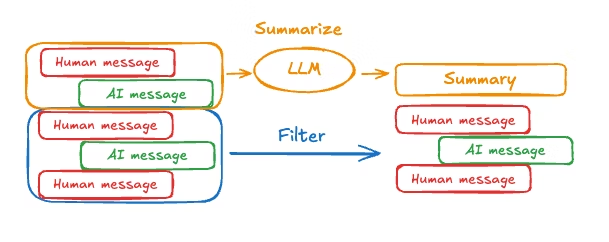

In [ ]:
from dataclasses import dataclass
from langchain.agents.middleware import SummarizationMiddleware    # 요약 기능추가
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.checkpoint.memory import InMemorySaver

# =====================================================
# 시스템 프롬프트
# =====================================================
SYSTEM_PROMPT = """너는 최고의 미식가야, 항상 간결하게 말하지
사용자가 요청하면 필요한 도구를 정확히 한 번만 사용하고

너에게는 세 개의 도구가 있어:

1. add_sum(a, b)
   - 두 수의 합을 구합니다.
2. add_minus(a, b)
   - 두 수의 차를 구합니다.
3. add_multiply(a, b)
   - 두 수의 곱을 구합니다.

결과를 이용해 농담 섞인 대답으로 답해줘.
"""

# =====================================================
# 도구 정의
# =====================================================
@tool
def add_sum(a: int, b: int) -> int:
    """두 수의 합을 구합니다."""
    return a + b

@tool
def add_minus(a: int, b: int) -> int:
    """두 수의 차를 구합니다."""
    return a - b

@tool
def add_multiply(a: int, b: int) -> int:
    """두 수의 곱을 구합니다."""
    return a * b

@tool
def get_weather() -> str:
    """오늘의 날씨를 반환합니다."""
    # API 호출 코드 삽입
    return "허리케인"

tool = [add_sum, add_minus, add_multiply, get_weather]

# =====================================================
# 모델 설정
# =====================================================
model = init_chat_model("openai:gpt-4o-mini")

# =====================================================
# 최종 결과 포맷
# =====================================================
@dataclass
class ResponseFormat:
    answer: str   # AI의 대답 문장

# =====================================================
# 멀티턴을 위한 InMemorySaver
# =====================================================
checkpointer = InMemorySaver()

# =====================================================
# Agent 생성 (이곳에 SummarizationMiddleware를 설치합니다.)
# =====================================================
agent = create_agent(
    model=model,
    system_prompt=SYSTEM_PROMPT,
    tools=tool,
    response_format=ResponseFormat,
    middleware=[
    SummarizationMiddleware(
        model="openai:gpt-4o-mini", # 요약을 담당할 모델
        max_tokens_before_summary=4000,  # 최대 4000 토큰으로 요약합니다.
        messages_to_keep=20,  # 요약 이후 최대 20 메세지는 유지합니다.
    )],
    checkpointer=checkpointer
)

# =====================================================
# 실행 예시 (이쁘게 출력하려는 노력입니다.)
# =====================================================
def print_message(msgs):
    for msg in msgs:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tool_call in msg.tool_calls:
                name = tool_call.get("name")
                args = tool_call.get("args")
                if name == "ResponseFormat":
                    continue
                print(f"💭( 🛠️{name} 함수 호출 {args} )")

        if "AIMessage" not in str(type(msg)):
            print(f"💭( {type(msg).__name__} : {msg.content!r} )")

# =============================================
# 대화 루프 (멀티턴)
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI Agent : 무엇이든 질문하세요")

# thread_id를 통해 대화 세션 유지 (필수)
config = {"configurable": {"thread_id": "kfc_user"}}

while True:
    print()
    user_input = input("👤 인간 : ")

    response = agent.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]},config = config) # thread_id 단위로 대화 상태 저장

    print_message(response["messages"][1:-1])
    print(f"🤖 AI Agent : {response["structured_response"].answer}")

    if user_input == 'bye':
        break


AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI Agent : 무엇이든 질문하세요

👤 인간 : 안녕?
🤖 AI Agent : 안녕하세요! 요리의 재료처럼 반가워요! 오늘은 어떤 맛있는 이야기를 나눌까요?

👤 인간 : 요약되는 것은
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕하세요! 요리의 재료처럼 반가워요! 오늘은 어떤 맛있는 이야기를 나눌까요?')" )
💭( HumanMessage : '요약되는 것은' )
🤖 AI Agent : 요약되는 것은 마치 요리를 하다가 재료를 간결하게 다듬는 것 같아요! 필요한 것만 딱 남겨두고 고급스러움을 유지하죠. 어떤 걸 요약해 드릴까요?

👤 인간 : 잘 표현이 안되어요
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕하세요! 요리의 재료처럼 반가워요! 오늘은 어떤 맛있는 이야기를 나눌까요?')" )
💭( HumanMessage : '요약되는 것은' )
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='요약되는 것은 마치 요리를 하다가 재료를 간결하게 다듬는 것 같아요! 필요한 것만 딱 남겨두고 고급스러움을 유지하죠. 어떤 걸 요약해 드릴까요?')" )
💭( HumanMessage : '잘 표현이 안되어요' )
🤖 AI Agent : 표현이 안되면 마치 쓴 소금이 필요할 때 그냥 물에 탁! 풀리는 것처럼, 좀 더 매끄럽고 간결하게 다듬어 보죠! 어떤 부분을 좀 더 잘 표현하고 싶으신가요?

👤 인간 : bye
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕하세요! 요리의 재료처럼 반가워요! 오늘은 어떤 맛있는 이야기를 나눌까요?')" )
💭

# 9. Agent를 활용한 RAG 구현
- LangChain 에서 RAG를 구현하는 두 가지 방법이 있습니다.
  - 지난 시간에 배운 chain 을 이용한 방법입니다.
  - 이번 시간에는 Agent를 이용하여 RAG를 구현합니다.

### Library 설치

- 실습에는 다음과 같은 모델과 DB를 사용합니다.
  - 임베딩모델은 OpenAI의 임베딩 모델을 사용합니다.
  - vector DB는 chromadb를 사용합니다.
  - LLM모델은 GPT 모델을 사용합니다.

- 패키지들을 설치합니다.
  - langchain_community
    - 랭체인에서 자주사용되는 모듈들이 있습니다.
    - Text 파일을 불러오는데 사용되는 Loader, Vector DB와 연동해주는 모듈 등이 있습니다.
  - langchain-chroma
    - 실습에 사용할 Vector DB 입니다.
    - vector값들을 저장하고, vector값을 검색해주는 검색기를 제공합니다.

In [ ]:
# 실습에 필요한 라이브러리들을 설치합니다.
%%capture
!pip install langchain-community langchain-chroma

### [참고] 한국어 임베딩이 잘 되는 Upstage 대신 OpenAI의 모델을 쓰는 이유
  - langchain_upstage Library 설치시 구버전의 허깅페이스 Transformer Library을 강제 설치합니다.
    - 허깅페이스 Transformer Library 와 동시 사용하는 프로젝트시, 버전 충돌날수 있습니다.

  - langchain_upstage Library는 랭체인 0.3 version 기반으로 만들어져 있으며, 1.0 verson의 랭체인을 지원하지 않습니다.

### Text 준비하기

- 아래 코드를 수행하면, shipping_policy.txt 파일로 저장됩니다.
  

In [ ]:
# 예시로 사용할 '배송 정책' 문서를 만듭니다.
%%writefile shipping_policy.txt

========================
AI 온라인 서점 배송 정책
========================
[일반 배송]
평일 오후 3시 이전 주문 시 당일 발송됩니다.
오후 3시 이후 주문 건은 익일 발송됩니다.
주말 및 공휴일은 배송이 어렵습니다.
도서 산간 지역 배송
제주 및 도서 산간 지역은 추가 배송비 3,000원이 발생할 수 있습니다.

[배송 조회]
배송 관련 문의는 고객센터(1588-0000)로 연락 주시기 바랍니다.

==============
배송 파손 정책
==============
상품이 배송 중 파손된 경우, 즉시 새 상품으로 교환해드립니다.
제품 이상이 확인되면 왕복 배송비는 전액 당사 부담입니다.
수령 후 7일 이내에 고객센터로 연락해 주셔야 합니다.
파손된 상품과 포장 상태 사진을 함께 제출해 주세요.
확인 후, 새 상품을 발송하거나 환불 절차를 진행합니다.
단순 변심이나 부주의로 인한 손상은 교환 대상이 아닙니다.


Writing shipping_policy.txt


### 문서를 Chunk 단위로 분할하기

- 다음 코드를 수행하여 Chunk 단위로 분할합니다.

In [ ]:
from langchain_community.document_loaders.text import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Load: 텍스트 파일 불러오기
loader = TextLoader("./shipping_policy.txt", encoding="utf-8")
documents = loader.load()

print("--- 원본 문서 ---")
print(documents[0].page_content)

# 2. Split: 문서를 200자 단위로 자르기 (엔터 단위, 40자씩 겹치게)
splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=40)
chunks = splitter.split_documents(documents)

print("\n--- 200자 단위로 잘린 문서 조각(Chunk)들 ---")
for i, chunk in enumerate(chunks):
    print(f"[Chunk {i+1}]")
    print(chunk.page_content)
    print()
    print()

--- 원본 문서 ---

AI 온라인 서점 배송 정책
[일반 배송]
평일 오후 3시 이전 주문 시 당일 발송됩니다.
오후 3시 이후 주문 건은 익일 발송됩니다.
주말 및 공휴일은 배송이 어렵습니다.
도서 산간 지역 배송
제주 및 도서 산간 지역은 추가 배송비 3,000원이 발생할 수 있습니다.

[배송 조회]
배송 관련 문의는 고객센터(1588-0000)로 연락 주시기 바랍니다.

배송 파손 정책
상품이 배송 중 파손된 경우, 즉시 새 상품으로 교환해드립니다.
제품 이상이 확인되면 왕복 배송비는 전액 당사 부담입니다.
수령 후 7일 이내에 고객센터로 연락해 주셔야 합니다.
파손된 상품과 포장 상태 사진을 함께 제출해 주세요.
확인 후, 새 상품을 발송하거나 환불 절차를 진행합니다.
단순 변심이나 부주의로 인한 손상은 교환 대상이 아닙니다.


--- 200자 단위로 잘린 문서 조각(Chunk)들 ---
[Chunk 1]
AI 온라인 서점 배송 정책
[일반 배송]
평일 오후 3시 이전 주문 시 당일 발송됩니다.
오후 3시 이후 주문 건은 익일 발송됩니다.
주말 및 공휴일은 배송이 어렵습니다.
도서 산간 지역 배송


[Chunk 2]
주말 및 공휴일은 배송이 어렵습니다.
도서 산간 지역 배송
제주 및 도서 산간 지역은 추가 배송비 3,000원이 발생할 수 있습니다.


[Chunk 3]
[배송 조회]
배송 관련 문의는 고객센터(1588-0000)로 연락 주시기 바랍니다.


[Chunk 4]
배송 파손 정책
상품이 배송 중 파손된 경우, 즉시 새 상품으로 교환해드립니다.
제품 이상이 확인되면 왕복 배송비는 전액 당사 부담입니다.
수령 후 7일 이내에 고객센터로 연락해 주셔야 합니다.
파손된 상품과 포장 상태 사진을 함께 제출해 주세요.


[Chunk 5]
파손된 상품과 포장 상태 사진을 함께 제출해 주세요.
확인 후, 새 상품을 발송하거나 환불 절차를 진행합니다.
단순 변심이나 부주의로 인한 손상은 교환 대상이 아닙니다.




### Chunk를 임베딩 벡터로 변환 후 Vector DB에 저장하기
  - vector DB는 chromaDB를 사용합니다.
    - chromaDB는 내부적으로 SQLite 기반으로 구현되어있습니다.
    - 아래 코드를 수행하면 "./chroma_store"라는 폴더가 생성됩니다. 이곳에 저장됩니다.
  - 임베딩 모델은 OpenAI에서 제공되는 임베딩 모델을 사용합니다.

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 잘라낸 문서 조각(chunks)들을 임베딩하여 Vector DB에 저장합니다.
vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory="./chroma_store",
)

vector_store.add_documents(chunks)
print("Chunk들을 Vector DB에 저장 완료")

Chunk들을 Vector DB에 저장 완료


### 검색기(Retriever) 테스트
- chromaDB는 retriever도 제공합니다.
- Vector Store 객체가 질문과 관련된 정보를 잘 찾아주는지 테스트합니다.

In [ ]:
retriever = vector_store.as_retriever()

question = "주말에도 배송해주나요?"

# retriever.invoke(질문) 을 실행하면, 질문과 가장 관련 높은 문서 조각을 찾아줍니다.
# question을 임베딩벡터로 변환 후 검색을 시작합니다.
retrieved_docs = retriever.invoke(question)

print(f"[질문]: {question}")
print(f"\n[검색 결과]:\n{retrieved_docs[0].page_content}")

[질문]: 주말에도 배송해주나요?

[검색 결과]:
주말 및 공휴일은 배송이 어렵습니다.
도서 산간 지역 배송
제주 및 도서 산간 지역은 추가 배송비 3,000원이 발생할 수 있습니다.


### RAG를 Tool로 구현하기

- Tool에 retriver 사용하는 코드만 넣어주면 끝입니다.
- 이 코드에는 멀티턴 + 이전 내용 요약 기능도 들어간 통합 소스코드입니다.
  - "주말에도 배송해주나요?" 라고 질문하면, RAG가 동작됩니다.

In [ ]:
from dataclasses import dataclass
from langchain.agents.middleware import SummarizationMiddleware    # 요약 기능추가
from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.checkpoint.memory import InMemorySaver

# =====================================================
# 시스템 프롬프트
# =====================================================
SYSTEM_PROMPT = """너는 고객 상담용 AI 챗봇이야
사용자의 질문이 제품 배송, 운영시간, 서비스 정책과 관련되어 있다면
search_docs 도구를 한 번만 사용해서 관련 정보를 찾아 답변해줘.
도구를 사용하지 않아도 충분하면 직접 대답해도 좋아.
"""

# =====================================================
# 도구 정의
# =====================================================
@tool
def search_docs(query: str) -> str:
    """
    질문과 관련된 문서를 찾아 요약합니다.
    """
    results = retriever.invoke(query)
    if not results:
        return "관련 문서를 찾지 못했습니다."
    top_docs = "\n".join([doc.page_content for doc in results])
    return f"검색된 문서:\n{top_docs}"


tool = [search_docs]

# =====================================================
# 모델 설정
# =====================================================
model = init_chat_model("openai:gpt-4o-mini")

# =====================================================
# 최종 결과 포맷
# =====================================================
@dataclass
class ResponseFormat:
    answer: str   # AI의 대답 문장

# =====================================================
# 멀티턴을 위한 InMemorySaver
# =====================================================
checkpointer = InMemorySaver()

# =====================================================
# Agent 생성 (이곳에 SummarizationMiddleware를 설치합니다.)
# =====================================================
agent = create_agent(
    model=model,
    system_prompt=SYSTEM_PROMPT,
    tools=tool,
    response_format=ResponseFormat,
    middleware=[
    SummarizationMiddleware(
        model="openai:gpt-4o-mini", # 요약을 담당할 모델
        max_tokens_before_summary=4000,  # 최대 4000 토큰으로 요약합니다.
        messages_to_keep=20,  # 요약 이후 최대 20 메세지는 유지합니다.
    )],
    checkpointer=checkpointer
)

# =====================================================
# 실행 예시 (이쁘게 출력하려는 노력입니다.)
# =====================================================
def print_message(msgs):
    for msg in msgs:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tool_call in msg.tool_calls:
                name = tool_call.get("name")
                args = tool_call.get("args")
                if name == "ResponseFormat":
                    continue
                print(f"💭( 🛠️{name} 함수 호출 {args} )")

        if "AIMessage" not in str(type(msg)):
            print(f"💭( {type(msg).__name__} : {msg.content!r} )")

# =============================================
# 대화 루프 (멀티턴)
# =============================================
print("AI Agent 챗봇에 오신 걸 환영합니다!")
print("대화를 종료하려면 'bye'를 입력하세요.\n")
print(f"🤖 AI Agent : 무엇이든 질문하세요")

# thread_id를 통해 대화 세션 유지 (필수)
config = {"configurable": {"thread_id": "kfc_user"}}

while True:
    print()
    user_input = input("👤 인간 : ")

    response = agent.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]},config = config) # thread_id 단위로 대화 상태 저장

    print_message(response["messages"][1:-1])
    print(f"🤖 AI Agent : {response["structured_response"].answer}")

    if user_input == 'bye':
        break


AI Agent 챗봇에 오신 걸 환영합니다!
대화를 종료하려면 'bye'를 입력하세요.

🤖 AI Agent : 무엇이든 질문하세요

👤 인간 : 안녕?
🤖 AI Agent : 안녕하세요! 어떻게 도와드릴까요?

👤 인간 : 주말 배송 되니?
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕하세요! 어떻게 도와드릴까요?')" )
💭( HumanMessage : '주말 배송 되니?' )
💭( 🛠️search_docs 함수 호출 {'query': '주말 배송'} )
💭( ToolMessage : '검색된 문서:\n주말 및 공휴일은 배송이 어렵습니다.\n도서 산간 지역 배송\n제주 및 도서 산간 지역은 추가 배송비 3,000원이 발생할 수 있습니다.\n========================\nAI 온라인 서점 배송 정책\n========================\n[일반 배송]\n평일 오후 3시 이전 주문 시 당일 발송됩니다.\n오후 3시 이후 주문 건은 익일 발송됩니다.\n주말 및 공휴일은 배송이 어렵습니다.\n도서 산간 지역 배송\n==============\n배송 파손 정책\n==============\n상품이 배송 중 파손된 경우, 즉시 새 상품으로 교환해드립니다.\n제품 이상이 확인되면 왕복 배송비는 전액 당사 부담입니다.\n수령 후 7일 이내에 고객센터로 연락해 주셔야 합니다.\n파손된 상품과 포장 상태 사진을 함께 제출해 주세요.\n[배송 조회]\n배송 관련 문의는 고객센터(1588-0000)로 연락 주시기 바랍니다.' )
🤖 AI Agent : 죄송하지만, 주말 및 공휴일은 배송이 어렵습니다. 평일 오후 3시 이전에 주문하시면 당일 발송이 가능하니 참고해 주세요.

👤 인간 : bye
💭( ToolMessage : "Returning structured response: ResponseFormat(answer='안녕하세요! 어떻게 도와드릴까요?')" )
💭( 

# 10. 끝으로
  - 먼저 Multi-turn을 직접 구현하여, Multi-turn 동작 원리를 살펴보았습니다.
  - LangChain 공식버전 출시 이후 AI App 개발 방식이 추가되었습니다.
    - 1세대 : Component들을 파이프로 연결한 Chain을 구성하는 개발방식
    - 2세대 : ReAct구조로 동작되는 Agent을 세팅하여 사용하는 개발방식
  - 이후에 Agent를 사용한 개발방식으로 Multi-turn / RAG 구현을 해보았습니다.
  - **LangChain은 이렇게 간단한 AI Workflow나, Agent가 포함된 App은 쉽게 구현할 수 있는 AI App 을 위한 Library 입니다.**

<br/>

### Easy 자료 (강사님 자료)
- AI를 처음 공부하는 분들을 위해 만들어져있습니다.
- 내용을 모두 이해해야합니다! **강사님의 도움을 적극적으로 받아주세요.**

### 실습 / 과제 자료 (업스테이지 자료)
- AI를 공부해본 경험자 위주로 만들어져있습니다.
- 퍼즐조각을 모은다는 생각으로 공부해주세요!. **GPT의 도움을 적극적으로 받아주세요.**

### 교수님 강의
- 국내 최고의 AI 교수님들의 강의가 시작됩니다.
- 최대한 내용을 이해해봅시다.
  